This is the kaggle version of a Pierre Auger Observatory Open Data notebook. You can run it by clicking on "Copy and Edit" in the top right corner.

In [ ]:
![ -d /kaggle/input/release-2021-v1/augeropendata ] && [ ! -d augeropendata ] && ln -s /kaggle/input/release-2021-v1/augeropendata augeropendata  # kaggle specific linking dataset to augeropendata directory

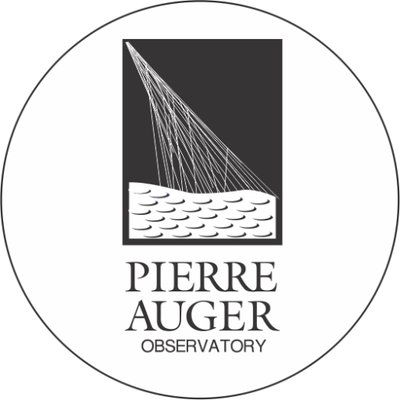
# Raw energy Spectrum

<i>Notebook released together with the Pierre Auger Observatory Open Data release 2021 (<a href="https://doi.org/10.5281/zenodo.4487613">DOI 10.5281/zenodo.4487613</a>). More information at the <a href="https://www.auger.org/opendata/">Auger open data website</a>.</i>

In this notebook we derive the raw energy spectrum as measured by the Pierre Auger Observatory Surface Detector above $ 2.5 \times 10^{18} $ eV.

## Notebook setup

In [ ]:
# Data analysis tools
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats

In [ ]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Default values for plots
plt.rcParams["figure.figsize"] = [14, 9] # figure width and height
plt.rcParams["font.size"] = 20

In [ ]:
# Jupyter/ IPython formatting
from IPython.display import Math, Latex, display

$\newcommand{\U}[1]{\,\mathrm{#1}}
\newcommand{\UU}[1]{\mathrm{#1}}$

In [ ]:
# Data loading, encapsulated to make it less installation and OS dependant
import os.path
from zipfile import ZipFile
def AugerOpen(fdir, file):
    """
    Loads a file from the auger open data release. Can be either in the local directory,
    in the parent directory or in the augeropendata directory.
    File is identified by it directory *fdir* and filename *file* and can be found in the directory
    or in a zip file.
    """
    for loc in [".", "..", "augeropendata", "data"]:
        fname = os.path.join(loc, fdir, file)
        if os.path.isfile(fname):
            return open(fname)
        zname=os.path.join(loc, fdir + ".zip")
        if os.path.isfile(zname):
            with ZipFile(zname) as myzip:
                return myzip.open(os.path.join(fdir, file))
    raise FileNotFoundError(os.path.join(fdir, file))

In this dataset we use 10% of the total Surface Detector data as published in [Phys. Rev. D 102, 062005 (2020)](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.102.062005) ( [arXiv:2008.06486v2](https://arxiv.org/abs/2008.06486) ) recorded between January 1st 2004 and August 31st 2018. We use events with zenith angle less than 60 degrees and energies above $2.5\times10^{18}$ eV.

In [ ]:
data = pd.read_csv(AugerOpen("summary", "dataSummary.csv"))
energy = data.drop_duplicates('id')["sd_energy"] 

The exposure is calculated according to [Nucl. Instrum. Methods A 613, 29 (2010)](https://www.sciencedirect.com/science/article/abs/pii/S0168900209021688) ( [arXiv:1111.6764](https://arxiv.org/abs/1111.6764) ) .
For energies above $2.5 \times 10^{18}$ eV, the detection efficiency becomes larger than 97% and the exposure is obtained from the integration of the aperture of the array over the observation time. The aperture is in turn obtained as the effective area under zenith angle $\theta$, $A \cos(\theta)$, integrated over the solid angle within which the showers are observed. $A$ is well defined as a consequence of the hexagonal structure of the array. Each station that has six adjacent, data taking neighbors, contributes a cell of area $A_{cell} = 1.95 \mathrm{km}^{2}$; the corresponding aperture for showers with $\theta < 60^{\circ}$ is 4.59 $\mathrm{km}^{2} \mathrm{sr}$.

In [ ]:
data = data[data["sd_exposure"]>0]
data = data.sort_values(by='sdid')
exposure = data["sd_exposure"].iat[-1]
Latex(f'The exposure is ${exposure:7.1f} \\U{{km}}^2 \\U{{sr}} \\U{{year}}$.')

Define the energy bins, selected to be of constant width in the decimal logarithm of the energy ($ \Delta \mathrm{log}_{10}(E) = 0.1$).

In [ ]:
log_E_min = 0.4
E_bins = 20
E_bin_size = 0.1
log_E_max = log_E_min + E_bins * E_bin_size

Check the presence of events above the highest energy interval.

In [ ]:
n_under = energy.where(energy < pow(10., log_E_min)).count()
n_over = energy.where(energy > pow(10., log_E_max)).count()
Latex(f'{n_over} events are above log10 (E) = {18+log_E_max}.')

In [ ]:
log_bins = np.linspace(log_E_min, log_E_max, E_bins + 1)
log_bin_centers = log_bins[:-1] + 0.05
bins = pow(10, log_bins);
bin_energy = pow(10, log_bin_centers)
bin_width = bins[1:] - bins[:-1]

Fill the histogram to get the number of events in each energy bin.

In [ ]:
h = np.histogram(energy, bins)[0]

## Normalize spectrum and estimate  the statistical uncertainies

The errors are asymmetric Poisson errors. The upper and lower limits of the 68% confidence interval for a count of $N$ events falling in each bin are given by
\begin{align}
N_{\mathrm{lower}} &= \frac{1}{2} F^{-1}_{\chi^2}(\alpha; 2N)\\
N_{\mathrm{upper}} &= \frac{1}{2} F^{-1}_{\chi^2}(1 - \beta; 2(N + 1))\\
\end{align}
where $F^{-1}_{\chi^2}$ is the quantile of the $\chi^2$ distribution for the indicated number of degrees of freedom. The upper and lower tail probabilities $\alpha$ and $\beta$ are equal and chosen to have the central confidence interval of 68%, i.e., 
$1 - \alpha - \beta = 0.68$. This gives us $\alpha = \beta = 0.16$.
For more information, check the [section on  statistics of the PDG](https://pdg.lbl.gov/2020/reviews/rpp2020-rev-statistics.pdf).

**Note**: the lim_low variable is undefined for a count $N = 0$ and the function call returns NaN. We use `np.nan_to_num` to convert the lower limit to zero in the case.

In [ ]:
alpha = 0.16
beta = 0.16
lim_low = (h - np.nan_to_num(0.5 * scipy.stats.chi2.ppf(alpha, 2 * h)) )
lim_up = ( 0.5 * scipy.stats.chi2.ppf(1 - beta, 2 * (h + 1)) - h)

Identify the bins with events and those with no events. In bins without events we calculate upper limits.

In [ ]:
cut_nz = h > 0
cut_z = h == 0

The raw flux is calculated as the ratio $ \frac{ N (E) }{\epsilon \Delta E} $ whereas $N(E)$ is the number of events falling in each bin, $\epsilon$ is the cumulated exposure and $\Delta E$ is the width of the energy bin. The resulting spectrum is not corrected for detector effects and it is therefore defined as raw energy spectrum.

In [ ]:
normalization = exposure * bin_width * 1e18
flux = h[cut_nz] / normalization[cut_nz]
flux_lower = lim_low[cut_nz] / normalization[cut_nz]
flux_upper = lim_up[cut_nz] / normalization[cut_nz]

To better visualize the changes in the slope, the flux is rescaled by $E^{3}$ whereas $E$ is the center of the logarithmic bin.

In [ ]:
bin_energy18 = bin_energy * 1e18
bin_energy18_3 = bin_energy18**3
flux_E3 = flux * bin_energy18_3[cut_nz]
flux_E3_lower = flux_lower * bin_energy18_3[cut_nz]
flux_E3_upper = flux_upper * bin_energy18_3[cut_nz]

For empty bins we calculate 90% CL upper limits according to Feldman Cousins (as defined in [Phys. Rev. D 102, 062005 (2020)](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.102.062005) ( [arXiv:2008.06486v2](https://arxiv.org/abs/2008.06486) ).

2.44 is the limit for a Poissonian distribution, 0 realizations and 90% CL.
See [Phys. Rev. D 57, 3873](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.57.3873) ( [arXiv:physics/9711021](https://arxiv.org/abs/physics/9711021) ) for more details.

In [ ]:
FC_90CL_0 = 2.44

Calculate the upper limits on the flux.

In [ ]:
FC_CL    = FC_90CL_0 / normalization[cut_z]
FC_CL_E3 = FC_CL * bin_energy18_3[cut_z]

## Spectrum plots

The raw energy spectrum is displayed here. On the X axis we put the energy (in eV) defined as the bin center, on the Y axis the flux (in $\mathrm{km}^{-2} \mathrm{sr}^{-1} \mathrm{yr}^{-1} \mathrm{eV}^{-1}$ units). The number of events detected in each bin is shown on the top of the data points.

In [ ]:
Y_0val = FC_CL * 0.9

plt.title("Spectrum with event counts")
plt.errorbar(bin_energy18[cut_nz], flux, [flux_lower, flux_upper], fmt="o")
plt.errorbar(bin_energy18[cut_z], FC_CL, Y_0val, uplims=True, marker="None", color="steelblue", 
             markeredgecolor="r", markerfacecolor="r", linewidth=2.0, linestyle="None", capsize=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('E [eV]')
plt.ylabel(r'J$^{Raw}$(E) [km$^{-2}$ sr$^{-1}$ yr$^{-1}$ eV$^{-1}$]')

# expand the range in y to have space for the labels and upper limits
plt.ylim(flux[flux > 0].min()*0.01, flux.max()*7)

# add the counts to the points
for E, J, count in zip(bin_energy18, flux, h):
    if count > 0:
        plt.annotate(count, (E, J), rotation=30, va='bottom')

The raw energy spectrum, rescaled by $E^{3}$, is displayed here. On the X axis we put the energy (in eV) defined as the bin center while on the Y axis the flux multiplied by the third power of the energy (in $\mathrm{km}^{-2} \mathrm{sr}^{-1} \mathrm{yr}^{-1} \mathrm{eV}^{2}$ units). 


In [ ]:
Y_0val2 = FC_CL_E3 * 0.6
plt.title(r"Spectrum with flux")
plt.errorbar(bin_energy18[cut_nz], flux_E3, [flux_E3_lower, flux_E3_upper], fmt="o")
plt.errorbar(bin_energy18[cut_z], FC_CL_E3, Y_0val2, uplims=True, barsabove=True, marker="None", color="steelblue",
             markeredgecolor="r", markerfacecolor="r", linewidth=2.0, linestyle="None", capsize=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('E [eV]')
plt.ylabel(r'J$^{Raw}$(E) [km$^{-2}$ $\times$ E$^{3} $sr$^{-1}$ yr$^{-1}$ eV$^{2}$]')
None

The released data includes 5 events with energies larger than $10^{20}$ eV out of the 15  observed with the full data set [Phys. Rev. D 102, 062005 (2020)](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.102.062005) ( [arXiv:2008.06486v2](https://arxiv.org/abs/2008.06486) ). Considering that the exposure is about 10% of the total one, the probability to observe 5 or more events with energies larger than $10^{20}$ eV is about 1.9%. 
This is an upward fluctuation that cannot be interpreted as an excess of events.

The energy spectrum corrected for detector effects can be estimated from the raw spectrum using the matrix formalism addressed in [Phys. Rev. D 102, 062005 (2020)](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.102.062005) ( [arXiv:2008.06486v2](https://arxiv.org/abs/2008.06486) ).
With the released data set, the consistency between the resulting energy spectrum and the model used to characterize the flux with the full statistics (see eq. 9 and Tab. III of [Phys. Rev. D 102, 062005 (2020)](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.102.062005) (  [arXiv:2008.06486v2](https://arxiv.org/abs/2008.06486) ) can be quantified with a p-value of 75%.